In [1]:
# standard libraries
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal, norm
from scipy import linalg, stats
from particles import resampling as rs
import time
import importlib
import sys
sys.path.append('..')

import GaussianMixtureAlgorithms as algo
import utils as u
importlib.reload(algo)
importlib.reload(u)

<module 'utils' from '/Users/francescacrucinio/Documents/PAPERS/SUBMITTED/SMC-WFR/GaussianMixture/../utils.py'>

In [2]:
w = 1/2
sigma = 1
weights = np.array([w, 1-w])

In [3]:
m = 6
d = 1
LSI = 1 + (np.exp(m**2)+1)/2
LSI

2155615773557599.0

In [4]:
def gm1d_density(xx, m, w):
    return w*norm.pdf(xx, loc = 0, scale = 1) + (1-w)*norm.pdf(xx, loc = m, scale = 1)

xx = np.linspace(-3, 10, 100)
yy = gm1d_density(xx, m, w)

In [5]:
# ms = np.array([np.zeros(d), m*np.ones(d)])
ms = np.array([5*np.ones(d), 6*np.ones(d)])
# Sigmas = np.array([np.eye(d), np.eye(d)])
Sigmas = np.array([0.1*np.eye(d), 0.1*np.eye(d)])

In [6]:
true_mean = np.mean(ms, axis = 0)
true_var = np.zeros((d, d))
for i in range(2):
    true_var += Sigmas[i, :, :] + np.matmul((ms[i, :] - true_mean)[:, None], (ms[i, :] - true_mean)[:, None].T)
true_var = true_var/2

## Algorithms

In [7]:
N = 200
X0 = np.random.multivariate_normal(np.zeros(d), np.eye(d), size = N)
gamma = 0.05

In [8]:
component = np.random.randint(2, size = N)
true_sample = np.zeros((d, N))
for n in range(N):
      true_sample[:, n] = np.random.multivariate_normal(ms[component[n], :], Sigmas[component[n], :, :], size = 1)[0]

In [9]:
# diffuse target
Niter = 50
Niter_ula = Niter*4
Niter_mala = Niter
Niter_fr = int(Niter*1.5)
Niter_smcula = Niter
Niter_smcmala = Niter
# concentrated target

In [10]:
Nalgo = 6
Nrep = 50

ula_chain = np.zeros((Nrep, Niter_ula, d, N))
mala_chain = np.zeros((Nrep, Niter_mala, d, N))
accepted_mala_chain = np.zeros((Nrep, Niter_mala, N))
fr_x = np.zeros((Nrep, Niter_fr, d, N))
fr_w = np.zeros((Nrep, Niter_fr, N))
wfr_x = np.zeros((Nrep, Niter, d, N))
wfr_w = np.zeros((Nrep, Niter, N))
smcula_x = np.zeros((Nrep, Niter_smcula, d, N))
smcula_w = np.zeros((Nrep, Niter_smcula, N))
smcmala_x = np.zeros((Nrep, Niter_smcmala, d, N))
smcmala_w = np.zeros((Nrep, Niter_smcmala, N))

runtime = np.zeros((Nrep, Nalgo))

In [11]:
for i in range(Nrep):
    ### ULA
    start = time.time()
    ula_chain[i,:] = algo.ParallelULA(gamma, Niter_ula, ms, Sigmas, weights, X0)
    end = time.time()
    runtime[i, 0] = end-start
#     ### MALA
#     start = time.time()
#     mala_chain[i,:], accepted_mala_chain[i,:] = algo.ParallelMALA(gamma, Niter_mala, ms, Sigmas, weights, X0)
#     end = time.time()
#     runtime[i, 1] = end-start
    ### SMC-FR
    start = time.time()
    fr_x[i,:], fr_w[i,:] = algo.SMC_UnitFR(gamma, Niter_fr, ms, Sigmas, weights, X0)
    end = time.time()
    runtime[i, 2] = end-start
    ### SMC-WFR
    start = time.time()
    wfr_x[i,:], wfr_w[i,:] = algo.SMC_WFR(gamma, Niter, ms, Sigmas, weights, X0)
    end = time.time()
    runtime[i, 3] = end-start
#     ### SMC-ULA
#     start = time.time()
#     smcula_x[i,:], smcula_w[i,:] = algo.SMC_ULA(gamma, Niter_smcula, ms, Sigmas, weights, X0)
#     end = time.time()
#     runtime[i, 4] = end-start
#     ### SMC-MALA
#     start = time.time()
#     smcmala_x[i,:], smcmala_w[i,:] = algo.SMC_MALA(gamma, Niter_smcmala, ms, Sigmas, weights, X0)
#     end = time.time()
#     runtime[i, 5] = end-start

/Users/francescacrucinio/Documents/PAPERS/SUBMITTED/SMC-WFR/GaussianMixture/GaussianMixtureAlgorithms.py:25: RuntimeWarning: divide by zero encountered in log
  return np.log(np.sum(logpi, axis = 0))


In [12]:
avg_runtime = np.mean(runtime, axis = 0)
avg_runtime[3]/avg_runtime

/var/folders/yb/2yx4lkb90l57vb9ljkzffpq40000gn/T/ipykernel_86332/884018888.py:2: RuntimeWarning: divide by zero encountered in divide
  avg_runtime[3]/avg_runtime


array([0.90721666,        inf, 0.88526917, 1.        ,        inf,
              inf])

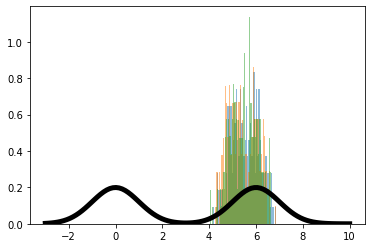

In [13]:
i = Nrep-1
plt.hist(ula_chain[i, -1, :, :].flatten(), density = True, bins = 50, alpha = 0.5);
plt.hist(fr_x[i, -1, :, :].flatten(), density = True, weights = fr_w[i, -1, :], bins = 50, alpha = 0.5);
plt.hist(wfr_x[i, -1, :, :].flatten(), density = True, weights = wfr_w[i, -1, :], bins = 50, alpha = 0.5);
plt.plot(xx, yy, c = 'black', lw = 5)

In [14]:
xx_ula = avg_runtime[0]/Niter_ula*np.arange(Niter_ula)
xx_mala = avg_runtime[1]/Niter_mala*np.arange(Niter_mala)
xx_fr = avg_runtime[2]/Niter_fr*np.arange(Niter_fr)
xx_wfr = avg_runtime[3]/Niter*np.arange(Niter)
xx_smcula = avg_runtime[4]/Niter_smcula*np.arange(Niter_smcula)
xx_smcmala = avg_runtime[5]/Niter_smcmala*np.arange(Niter_smcmala)

In [15]:
w1_ula = np.zeros((Nrep, Niter_ula))
w1_mala = np.zeros((Nrep, Niter_mala))
w1_fr = np.zeros((Nrep, Niter_fr))
w1_wfr = np.zeros((Nrep, Niter))
w1_smcula = np.zeros((Nrep, Niter_smcula))
w1_smcmala = np.zeros((Nrep, Niter_smcmala))

mmd_ula = np.zeros((Nrep, Niter_ula))
mmd_mala = np.zeros((Nrep, Niter_mala))
mmd_fr = np.zeros((Nrep, Niter_fr))
mmd_wfr = np.zeros((Nrep, Niter))
mmd_smcula = np.zeros((Nrep, Niter_smcula))
mmd_smcmala = np.zeros((Nrep, Niter_smcmala))

In [16]:
for j in range(Nrep):
    for i in range(Niter_ula):
        w1_ula[j, i] = stats.wasserstein_distance(ula_chain[j, i, :, :].flatten(), true_sample.flatten())
        mmd_ula[j, i] = u.mmd_rbf(true_sample.reshape(-1, 1), ula_chain[j, i, :, :].T)
#     for i in range(Niter_mala):
#         w1_mala[j, i] = stats.wasserstein_distance(mala_chain[j, i, :, :].flatten(), true_sample.flatten())
#         mmd_mala[j, i] = u.mmd_rbf(true_sample.reshape(-1, 1), mala_chain[j, i, :, :].T)
    for i in range(Niter):
        w1_wfr[j, i] = stats.wasserstein_distance(wfr_x[j, i, :, :].flatten(), true_sample.flatten(), u_weights = wfr_w[j, i, :])
        mmd_wfr[j, i] = u.mmd_rbf(true_sample.reshape(-1, 1), wfr_x[j, i, :, :].T, w = wfr_w[j, i, :])
    for i in range(Niter_fr):
        w1_fr[j, i] = stats.wasserstein_distance(fr_x[j, i, :, :].flatten(), true_sample.flatten(), u_weights = fr_w[j, i, :])
        mmd_fr[j, i] = u.mmd_rbf(true_sample.reshape(-1, 1), fr_x[j, i, :, :].T, w = fr_w[j, i, :])
#     for i in range(Niter_smcula):
#         w1_smcula[j, i] = stats.wasserstein_distance(smcula_x[j, i, :, :].flatten(), true_sample.flatten(), u_weights = smcula_w[j, i, :])
#         mmd_smcula[j, i] = u.mmd_rbf(true_sample.reshape(-1, 1), smcula_x[j, i, :, :].T, w = smcula_w[j, i, :])
#     for i in range(Niter_smcmala):
#         w1_smcmala[j, i] = stats.wasserstein_distance(smcmala_x[j, i, :, :].flatten(), true_sample.flatten(), u_weights = smcmala_w[j, i, :])
#         mmd_smcmala[j, i] = u.mmd_rbf(true_sample.reshape(-1, 1), smcmala_x[j, i, :, :].T, w = smcmala_w[j, i, :])
        

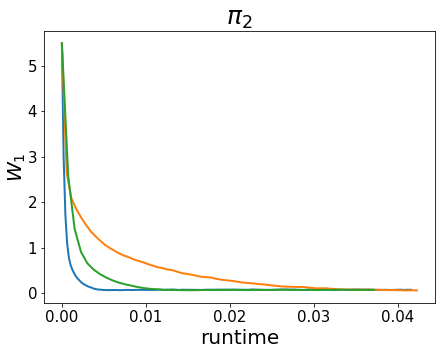

In [24]:
plt.figure(figsize = (7,5))
plt.plot(xx_ula, np.mean(w1_ula, axis = 0), label = 'ULA', lw = 2)
# plt.plot(xx_mala, np.mean(w1_mala, axis = 0), label = 'MALA')
plt.plot(xx_fr, np.mean(w1_fr, axis = 0), label = 'SMC-FR', lw = 2)
plt.plot(xx_wfr, np.mean(w1_wfr, axis = 0), label = 'SMC-WFR', lw = 2)
# plt.plot(xx_smcula, np.mean(w1_smcula, axis = 0), label = 'SMC-ULA')
# plt.plot(xx_smcmala, np.mean(w1_smcmala, axis = 0), label = 'SMC-MALA')
# legend = plt.legend(loc = 'lower center', bbox_to_anchor=(1, -0.5), ncol = 6, fontsize = 20)
plt.title('$\pi_2$', fontsize = 25)
plt.xlabel('runtime', fontsize = 20)
plt.ylabel('$W_1$', fontsize = 20, labelpad=-1);
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
# plt.savefig('w1_mixture2_runtime.pdf', bbox_inches="tight")

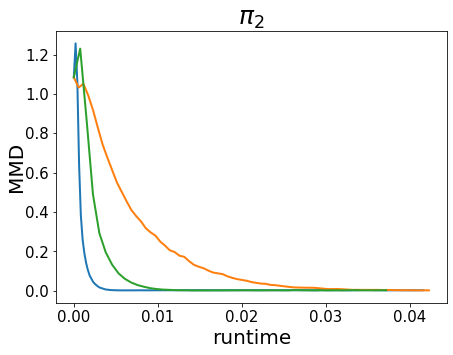

In [25]:
plt.figure(figsize = (7,5))
plt.plot(xx_ula, np.mean(mmd_ula, axis = 0), lw = 2)
# plt.plot(xx_mala, np.mean(mmd_mala, axis = 0))
plt.plot(xx_fr, np.mean(mmd_fr, axis = 0), lw = 2)
plt.plot(xx_wfr, np.mean(mmd_wfr, axis = 0), lw = 2)
# plt.plot(xx_smcula, np.mean(mmd_smcula, axis = 0))
# plt.plot(xx_smcmala, np.mean(mmd_smcmala, axis = 0))
plt.title('$\pi_2$', fontsize = 25)
plt.xlabel('runtime', fontsize = 20)
plt.ylabel('MMD', fontsize = 20, labelpad=-1)
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
# plt.savefig('mmd_mixture2_runtime.pdf', bbox_inches="tight")

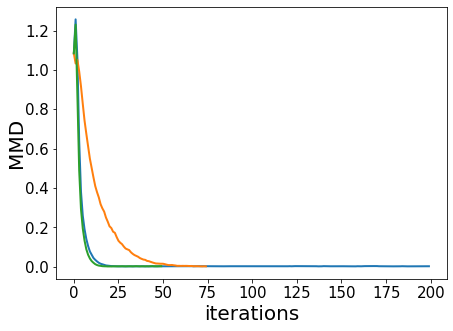

In [19]:
plt.figure(figsize = (7,5))
plt.plot(np.mean(mmd_ula, axis = 0), label = 'ULA', lw = 2)
# plt.plot(np.mean(mmd_mala, axis = 0))
plt.plot(np.mean(mmd_fr, axis = 0), label = 'SMC-FR', lw = 2)
plt.plot(np.mean(mmd_wfr, axis = 0), label = 'SMC-WFR', lw = 2)
# plt.plot(np.mean(mmd_smcula, axis = 0))
# plt.plot(np.mean(mmd_smcmala, axis = 0))
# legend = plt.legend(loc = 'lower center', bbox_to_anchor=(1, -0.5), ncol = 6, fontsize = 20)
plt.xlabel('iterations', fontsize = 20)
plt.ylabel('MMD', fontsize = 20, labelpad=-1)
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
# plt.savefig('mmd_mixture2.pdf', bbox_inches="tight")

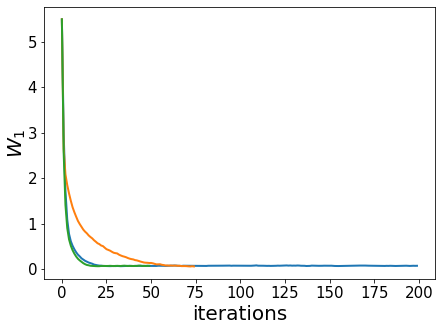

In [20]:
plt.figure(figsize = (7,5))
plt.plot(np.mean(w1_ula, axis = 0), label = 'ULA', lw = 2)
plt.plot(np.mean(w1_fr, axis = 0), label = 'SMC-FR', lw = 2)
plt.plot(np.mean(w1_wfr, axis = 0), label = 'SMC-WFR', lw = 2)
# legend = plt.legend(loc = 'lower center', bbox_to_anchor=(1, -0.5), ncol = 6, fontsize = 20)
plt.xlabel('iterations', fontsize = 20)
plt.ylabel('$W_1$', fontsize = 20, labelpad=-1)
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
# plt.savefig('w1_mixture2.pdf', bbox_inches="tight")

In [21]:
# def export_legend(legend, filename="legend_mixture.pdf", expand=[-5,-5,5,5]):
#     fig  = legend.figure
#     fig.canvas.draw()
#     bbox  = legend.get_window_extent()
#     bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
#     bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
#     fig.savefig(filename, dpi="figure", bbox_inches=bbox)

# export_legend(legend)
# plt.show()